# 第六週: 中文文集的情緒分析2

**Author:** 蔡睿澤<br>
**Date created:** 2023/03/22<br>
**Last modified:** 2023/03/25<br><br>
本週課程為「情緒分析2」，與情緒分析1不同，這次會使用中研院提供的CKIP自然語言處理工具包，但其中不像coreNLP有提供情緒分析套件，所以在此介紹一款用於中文情緒分析的套件SnowNLP，是Courpus-base的情緒分析，不是使用情緒字典，而是使用預訓練的情緒分析模型或演算法，給與整個文章一個情緒分數。情緒分析2的步驟會因所要分析之語言不同而有所差異，在這個Jupyter Notebook當中將會展示「中文」的情緒分析，並且搭配python程式碼進行講解。在後面的內容中會介紹CKIP、分析方法、SnowNLP

## 大綱
1. 套件說明
2. CKIP 介紹
    + 2.1 安裝CKIP
    + 2.2 利用CKIP進行自然語言處理
3. CKIP 標註
    + 3.1 將抓取結果用CKIP進行處理
    + 3.2 探索分析 - NER
    + 3.3 探索分析 - POS
4. 利用SnowNLP進行情緒分析

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- CKIP: 全名為Chinese Knowledge and Information Processing，中研院開發的中文自然語言處理工具。
- stanza: 使用CoreNLP的官方套件
- wordcloud: 文字雲繪圖工具。
- matplotlib: 繪圖工具。
- SnowNLP: SnowNLP是一個可以方便的處理中文文本內容的python類庫，是受到了TextBlob的啟發而寫的。SnowNLP主要功能包括斷詞、詞性標註、情緒分析、漢字轉拼音、繁體轉簡體、關鍵詞提取以及文本摘要等等。

In [ ]:
# 安裝會使用到的套件
# 安裝ckiptagger前要先安裝tensorflow，有套件相依的問題
# %pip install ckiptagger[tf,gdown] wordcloud tweepy==3.10.0 SnowNLP

In [ ]:
# 確認當前工作目錄
# %pwd

In [80]:
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import configparser, re, os, io

from wordcloud import WordCloud, ImageColorGenerator
import tweepy as tw

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta

如果有重新裝package，記得需要restart kernel 才會使用更新後的套件

In [81]:
# 檢查推特api package 版本，建議使用 3.10.0
print(tw.__version__)

3.10.0


## 2. CKIP 介紹
- 是中研院詞庫小組開發的中文自然語言處理套件，其斷詞效果比起`jieba`效果更好，並且提供性命名實體辨識、詞性標註、句法分析
- github: https://github.com/ckiplab/ckiptagger

### 2.1 CKIP安裝

In [ ]:
data_utils.download_data_gdown("./") # gdrive-ckip # 下載ckip model

In [82]:
# To use CPU:
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

/opt/anaconda3/lib/python3.9/site-packages/ckiptagger/model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
/opt/anaconda3/lib/python3.9/site-packages/ckiptagger/model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
/opt/anaconda3/lib/python3.9/site-packages/ckiptagger/model_ner.py:57: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)


### 2.2 利用CKIP進行自然語言處理
透過ckip這個套件可以對文集進行斷詞、命名實體辨識、詞性標記等處理
+ CKIP 標註任務
    + 斷詞（ws）
        + 可以設定自己的辭典
            + `recommend_dictionary` 推薦字典
            + `coerce_dictionary` 強制字典
    + 實體辨識（ner）
    + 詞性標註（pos）
        + 名詞對應: https://ckip.iis.sinica.edu.tw/service/corenlp/

In [83]:
word_to_weight = {
    "魔法覺醒": 1,
    "睽違已久": 2,
}
dictionary1 = construct_dictionary(word_to_weight)
print(dictionary1)

[(4, {'魔法覺醒': 1.0, '睽違已久': 2.0})]


In [84]:
sentence_list = [
    "哈利波特魔法覺醒是一個中國網易代理的粉絲睽違已久的手遊app",
     "很多人滿心期待這款英國出品的遊戲，卻又害怕受傷害"
]

word_sentence_list = ws(sentence_list, coerce_dictionary = dictionary1)  # 斷詞
pos_sentence_list = pos(word_sentence_list)
entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

def print_word_pos_sentence(word_sentence, pos_sentence):
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence):
        print(f"{word}({pos})", end="\u3000")
    print()
    return
    
for i, sentence in enumerate(sentence_list):
    print()
    print(f"sentence {i}: {sentence}")
    print("\nPOS: ")
    print_word_pos_sentence(word_sentence_list[i],  pos_sentence_list[i])
    print("\nNER: ")
    for entity in sorted(entity_sentence_list[i]):
        print(entity)


sentence 0: 哈利波特魔法覺醒是一個中國網易代理的粉絲睽違已久的手遊app

POS: 
哈利波特(Nb)　魔法覺醒(Nb)　是(SHI)　一(Neu)　個(Nf)　中國(Nc)　網易(Nb)　代理(VC)　的(DE)　粉絲(Na)　睽違已久(VH)　的(DE)　手遊(Na)　app(FW)　

NER: 
(11, 13, 'NORP', '中國')
(13, 15, 'ORG', '網易')

sentence 1: 很多人滿心期待這款英國出品的遊戲，卻又害怕受傷害

POS: 
很多(Neqa)　人(Na)　滿心(D)　期待(VK)　這(Nep)　款(Nf)　英國(Nc)　出品(VC)　的(DE)　遊戲(Na)　，(COMMACATEGORY)　卻(D)　又(D)　害怕(VK)　受(VJ)　傷害(Na)　

NER: 
(9, 11, 'GPE', '英國')


## 3. CKIP 標註

### 3.1 將抓取結果用CKIP進行處理
資料來源：
+ 工作流程平台蒐集PTT 美食版(Food)所有文章
+ 關鍵字:「吃到飽」(1630筆)
+ 時間: 2020-01-10 ~ 2022-12-31

我們已經介紹過coreNLP的使用方式，現在來對PTT的資料使用coreNLP進行自然語言處理

In [85]:
## 讀取文章
df = pd.read_csv('./raw_data/zh/buffet_20_22.csv')
df.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,ideos,Food,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,[],111.250.1.231,2020-01-02 00:21:09,ptt
1,2,https://www.ptt.cc/bbs/Food/M.1577983692.A.794...,[抱怨]ATT4FUN乾杯點沙朗多注意,2020-01-02 16:42:10,justin81828,Food,餐廳名稱：乾杯\n\n 地址：ATT4FUN 乾杯\n 電話：02-87860808\n...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""KKyosuke"", ""...",118.169.82.96,2020-01-03 00:22:27,ptt
2,3,https://www.ptt.cc/bbs/Food/M.1577985452.A.477...,[食記]台北大安區六張犁站捷運小慧涼麵,2020-01-02 17:11:29,v84454058,Food,餐廳名稱：小慧涼麵\n 消費時間：2018年/11月起多訪\n 地址：台北市大安區臥...,[],123.194.196.149,2020-01-03 00:22:34,ptt


定義文字清理的相關function

In [86]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    final_res = []
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    
#     paragraphs = list(filter(None, article.split("\n")))
    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n")))
#     print(len(paragraphs))
#     print(paragraphs)
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except:
            _logger.info("error")
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

(2) CKIP 處理相關function

In [87]:
# 自定義辭典
with open('dict/user_dict.txt') as f:
    lines = f.read().splitlines()

dict = {k.split()[0]: k.split()[1] for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(dict)
print(dictionary2)

[(2, {'拌飯': 500.0, '嚼勁': 500.0}), (3, {'重口味': 500.0, '炸物區': 500.0, '雞腿排': 500.0, '鴛鴦鍋': 500.0, '醬料區': 500.0, '新馬辣': 500.0, '肉次方': 500.0, '雪花牛': 500.0, '梅花豬': 500.0, '自助區': 500.0, '新北市': 500.0, '壽喜燒': 500.0, '握壽司': 500.0, '火鍋料': 500.0, '鮭魚卵': 500.0, '土瓶蒸': 500.0, '信義店': 500.0, '文山店': 500.0, '大安店': 500.0, '忠孝店': 500.0}), (4, {'饗食天堂': 500.0, '漢來海港': 500.0, '肋眼牛排': 500.0, '石頭火鍋': 500.0, '平日晚餐': 500.0, '韓式炸雞': 500.0, '梅花豬肉': 500.0, '日本料理': 500.0, '玉米濃湯': 500.0, '生菜沙拉': 500.0, '天使紅蝦': 500.0, '麻辣鴨血': 500.0, '火烤兩吃': 500.0, '剝皮辣椒': 500.0, '一蘭拉麵': 500.0})]


In [88]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
#     print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id,word,pos]) 
#         print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
#     print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3],entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    for index, row in data_df.iterrows(): # document level    
#         print(f"\ndocument {index}") 

        # clean data
        result = [] 
        tmp = Sentence_Segmentation(row['artContent']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2) # set dictionary 
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        for i, sentence in enumerate(flat_list): # sentence level
#             print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'],sentence])            
            temp_tokens = get_pos(row['system_id'],word_sentence_list[i],  pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'],entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['system_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['system_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['system_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [89]:
pos_table, entity_table, sentence_table = get_nlp_result(df)

time costing: 1298.3148601055145


+ 欄位名稱介紹
    + pos_table 欄位:
        + system_id : ptt 貼文id
        + word: 原始斷詞
        + pos : part-of-speech,詞性
    + entity_table 欄位:
        + system_id : ptt 貼文id
        + word: 原始斷詞
        + ner: 命名實體
    + sentence_table 欄位:
        + system_id : ptt 貼文id
        + text: 原始斷句

In [90]:
pos_table.head(5) # word pos 列表

,system_id,word,pos
0,1,餐廳,Nc
1,1,名稱,Na
2,1,濃咖哩,Nb
3,1,消費,Na
4,1,時間,Na


In [91]:
entity_table.head(5) # word entity 列表

,system_id,word,ner
0,1,例年月,DATE
1,1,台北市,GPE
2,1,開封街,LOC
3,1,開封街高雄銀行,FAC
4,1,日式,GPE


In [92]:
# 檢查筆數正不正確
print(f"total posts numbers: {len(pos_table['system_id'].unique())}") # 1628篇文
print(f"posts have NER: {len(entity_table['system_id'].unique())}") # 1620篇有抓到ner

total posts numbers: 1628
posts have NER: 1620


In [93]:
# 將文章存成csv
pos_table.to_csv('raw_data/zh/pos_table_buffet.csv', index = False)
entity_table.to_csv('raw_data/zh/entity_table_buffet.csv', index = False)
sentence_table.to_csv('raw_data/zh/sentence_table_buffet.csv', index = False)

### 3.2 探索分析 - NER

將剛才分析的資料匯入

In [94]:
# 讀取已經執行完畢的結果
pos_table = pd.read_csv("raw_data/zh/pos_table_buffet.csv") 
entity_table = pd.read_csv("raw_data/zh/entity_table_buffet.csv") 
sentence_table = pd.read_csv("raw_data/zh/sentence_table_buffet.csv") 

### NER 種類分析
查看標註這個文集後辨識出哪一些實體種類

In [95]:
entity_table['ner'].unique()

array(['DATE', 'GPE', 'LOC', 'FAC', 'NORP', 'WORK_OF_ART', 'TIME',
       'PERSON', 'CARDINAL', 'ORG', 'LANGUAGE', 'ORDINAL', 'PRODUCT',
       'MONEY', 'QUANTITY', 'EVENT', 'PERCENT', 'LAW'], dtype=object)

In [96]:
ner_count = entity_table.groupby(['ner'])['ner'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(8)
ner_count

,ner,count
4,GPE,10318
0,CARDINAL,7162
3,FAC,3585
13,PERSON,3358
1,DATE,3320
9,NORP,3003
11,ORG,2419
7,LOC,2377


/var/folders/wb/4p2wtwfn0hbfl5wk9721_6gm0000gn/T/ipykernel_63821/3390866936.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


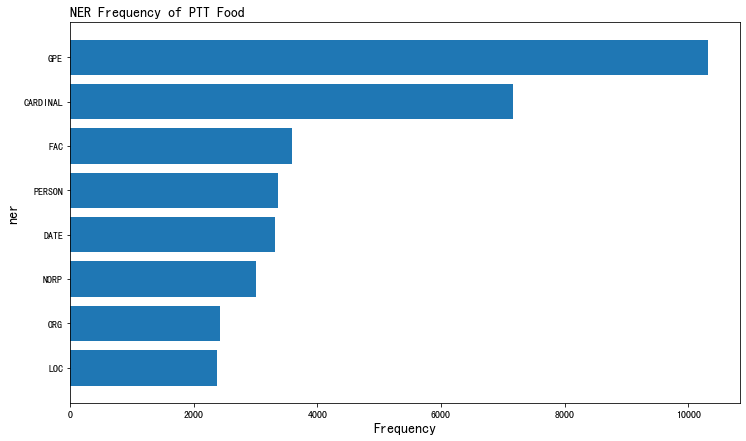

In [97]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency of PTT Food',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

### 涉及到的人名(PERSON)

/var/folders/wb/4p2wtwfn0hbfl5wk9721_6gm0000gn/T/ipykernel_63821/2044175467.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


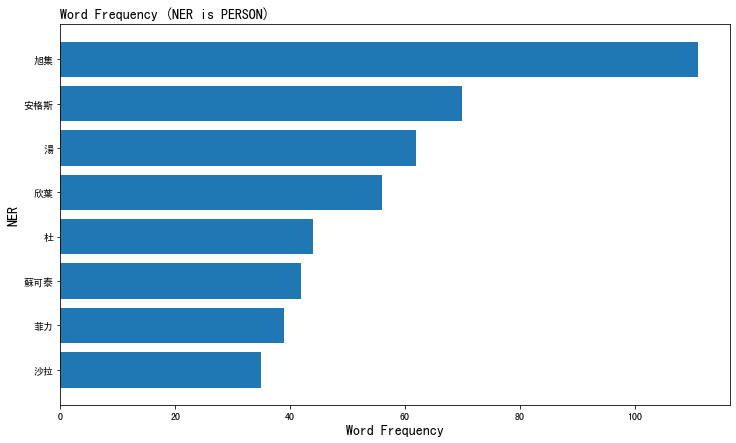

In [98]:
# 篩選ner為名詞的資料
l_noun = ["PERSON"]
PERSON = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前8個
ner_count = PERSON.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(8).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

看一下含特定關鍵字的貼文內容

In [102]:
keyword_list = ['旭集']
selected = df[df['artContent'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{selected.shape[0]}篇相關貼文")
selected.head(10)

旭集：37篇相關貼文


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
13,14,https://www.ptt.cc/bbs/Food/M.1578729503.A.F3E...,[食記]台北旭集假日午餐吃到飽松葉蟹干貝和牛,2020-01-11 07:52:14,yoci0722,Food,餐廳名稱：旭集和食集錦\n 消費時間：2020年/1月\n (例：20...,[],36.227.86.50,2020-01-12 00:19:09,ptt
68,69,https://www.ptt.cc/bbs/Food/M.1581924705.A.65E...,[食記]台北旭集-一位難求！索性直接去碰運氣..,2020-02-17 07:25:42,tiantian27,Food,餐廳名稱：旭集\n 消費時間：2020年/2月\n 地址：台北市信義區松仁路58號9...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""shink111"", ""...",111.240.31.20,2020-02-18 00:22:10,ptt
174,175,https://www.ptt.cc/bbs/Food/M.1586786166.A.E2B...,[食記]高雄饗食天堂-新菜單麵包蟹/鐵板羊肋排,2020-04-13 21:56:02,vhygdih,Food,餐廳名稱：饗食天堂 高雄店\n 消費時間：2020年/04月\n 地址:高雄市苓雅區...,[],114.47.8.7,2020-04-14 00:05:02,ptt
286,287,https://www.ptt.cc/bbs/Food/M.1591433309.A.C42...,Fw:[食記]台北信義旭集和食集錦遠百信義A13,2020-06-06 16:48:28,windsora,Food,作者: windsora (Me food★Meet Food) 看板: EatToDie\...,[],61.231.194.209,2020-06-07 00:05:10,ptt
388,389,https://www.ptt.cc/bbs/Food/M.1596368298.A.200...,[食記]台北旭集和食集錦究極美味日式吃到飽,2020-08-02 19:38:08,gillianshine,Food,圖文網誌好讀版：\nhttps://chantal1109.pixnet.net/blog/...,[],118.169.14.110,2020-08-03 00:26:35,ptt
406,407,https://www.ptt.cc/bbs/Food/M.1597070588.A.4A4...,[食記]台北旭集日本料理吃到飽晚餐4小時任你吃,2020-08-10 22:43:05,ke6221,Food,餐廳名稱：旭集和食集錦\n 消費時間：2020年/8月\n 地址：110台北市信義區...,[],39.11.230.97,2020-08-11 00:27:01,ptt
407,408,https://www.ptt.cc/bbs/Food/M.1597159954.A.EC4...,Fw:[食記]台北旭集~~黑鮪魚Toro吃到飽,2020-08-11 23:32:33,kenzo0228,Food,作者: kenzo0228 (Felix) 看板: EatToDie\n標題: [食記] 台...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""dogbydog"", ""...",118.168.207.33,2020-08-12 00:56:03,ptt
462,463,https://www.ptt.cc/bbs/Food/M.1599522543.A.C31...,[食記]旭集和食集錦SUNRISE吃到飽,2020-09-08 07:48:58,gypsygirl,Food,餐廳名稱：旭集和食集錦 SUNRISE\n 消費時間：2020年/8月\n 地址：1...,[],47.152.147.190,2020-09-09 00:05:25,ptt
634,635,https://www.ptt.cc/bbs/Food/M.1606649509.A.D4D...,[食記]『台北』饗響下午茶吃到飽,2020-11-29 19:31:46,yajuyeh,Food,餐廳名稱：『台北』饗響下午茶\n 消費時間：2020年/5月\n 地址：台北市信義區...,[],111.71.52.31,2020-11-30 00:08:53,ptt
749,750,https://www.ptt.cc/bbs/Food/M.1611952848.A.9A6...,[食記]台北旭集日式料理吃到飽SUNRISE,2021-01-30 04:40:44,gypsygirl,Food,餐廳名稱：旭集和食集錦 SUNRISE\n 消費時間：2020年/12月\n 地址：...,[],47.152.147.190,2021-01-31 00:26:29,ptt


可以看到在疫情期間，「吃到飽」主題中「旭集」的討論度最高，貼文類型多數為食記，推測是因為開幕時間剛好在疫情剛爆發的時候（2019年底），同時因為是人氣吃到飽餐廳「饗食天堂」的姐妹品牌，故引起民眾廣泛的介紹、嚐鮮與討論。

### 涉及到的組織(ORG)

/var/folders/wb/4p2wtwfn0hbfl5wk9721_6gm0000gn/T/ipykernel_63821/3690618897.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


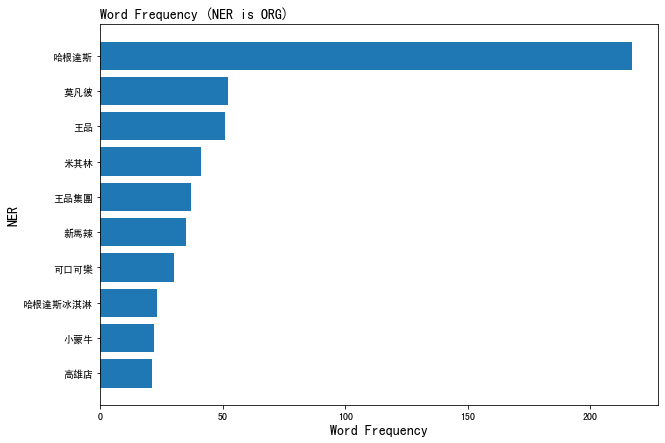

In [103]:
# 篩選ner為名詞的資料
l_noun = ["ORG"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

可以看到在多數的吃到飽食記之中，「哈根達斯」是多數食記會介紹到的一環，也間接反映出讀者對於吃到飽餐廳冰淇淋品牌的關注。

### 涉及到的民族、宗教、政治團體(NORP)

/var/folders/wb/4p2wtwfn0hbfl5wk9721_6gm0000gn/T/ipykernel_63821/2477643763.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


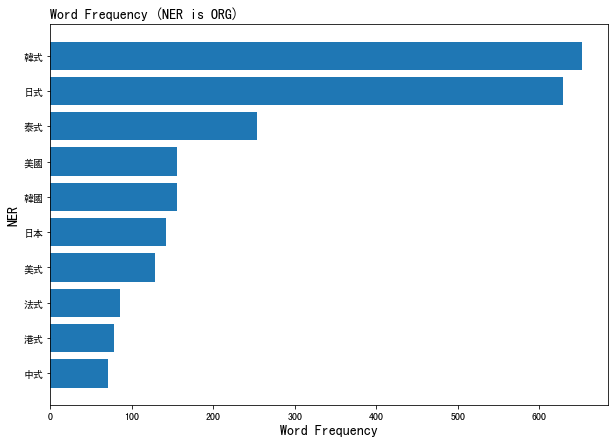

In [104]:
# 篩選ner為名詞的資料
l_noun = ["NORP"]
NORP = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = NORP.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

In [109]:
keyword_list = ['泰式']
selected = df[df['artContent'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{selected.shape[0]}篇相關貼文")
selected.head(3)

泰式：180篇相關貼文


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
7,8,https://www.ptt.cc/bbs/Food/M.1578202069.A.3C5...,[食記]Harbour漢來海港曼谷@BangkokICONSIAM,2020-01-05 05:21:47,nmlw,Food,這篇要分享的是~海鮮吃到飽餐廳Harbour，在台北大名鼎鼎的和來海港曼谷分店~\n\n圖文...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""alpina330"", ...",58.8.49.60,2020-01-05 00:21:49,ptt
9,10,https://www.ptt.cc/bbs/Food/M.1578285877.A.E52...,[食記][台南][東區]XM麻辣鍋德安店,2020-01-06 04:38:35,kuangyue,Food,餐廳名稱：XM麻辣鍋 德安店\n消費時間：109年1月\n地址：701台南市東區中華東路三段...,[],59.120.243.46,2020-01-06 00:20:44,ptt
35,36,https://www.ptt.cc/bbs/Food/M.1580563581.A.909...,[食記]新北板橋素食吃到飽果然匯(板橋店),2020-02-01 13:19:55,wonderfood,Food,餐廳名稱：\n果然匯(板橋店)\n消費時間：2019年/10月\n 地址：新北市板橋區中...,[],1.161.243.130,2020-02-02 00:19:04,ptt


### 3.3 探索分析 - POS

#### POS 種類分析
查看辨識出哪幾種POS

In [110]:
pos_table['pos'].unique()

array(['Nc', 'Na', 'Nb', 'FW', 'COMMACATEGORY', 'D', 'VD', 'VL', 'VC',
       'A', 'VF', 'VA', 'Nes', 'VH', 'VJ', 'Nep', 'Nf', 'P', 'Ncd', 'DE',
       'SHI', 'V_2', 'Neqa', 'Di', 'VG', 'Cbb', 'VK', 'Nh', 'Da', 'Caa',
       'VCL', 'Nd', 'Cab', 'Dfa', 'VHC', 'VE', 'Ng', 'Neu', 'VB', 'T',
       'VAC', 'Cba', 'Dk', 'VI', 'Dfb', 'Neqb', 'I', 'Nv',
       'PARENTHESISCATEGORY', 'DM', 'PERIODCATEGORY', 'COLONCATEGORY',
       'ETCCATEGORY', 'DASHCATEGORY', 'PAUSECATEGORY',
       'EXCLAMATIONCATEGORY'], dtype=object)

看看除了標點符號，大部分的POS都是哪一類

In [112]:
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(12)
pos_count

,pos,count
18,Na,284923
5,D,124221
45,VH,91747
39,VC,88049
7,DE,58008
20,Nc,47171
10,Dfa,33034
28,Nf,31076
32,P,24943
4,Cbb,24550


/var/folders/wb/4p2wtwfn0hbfl5wk9721_6gm0000gn/T/ipykernel_63821/2478466374.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


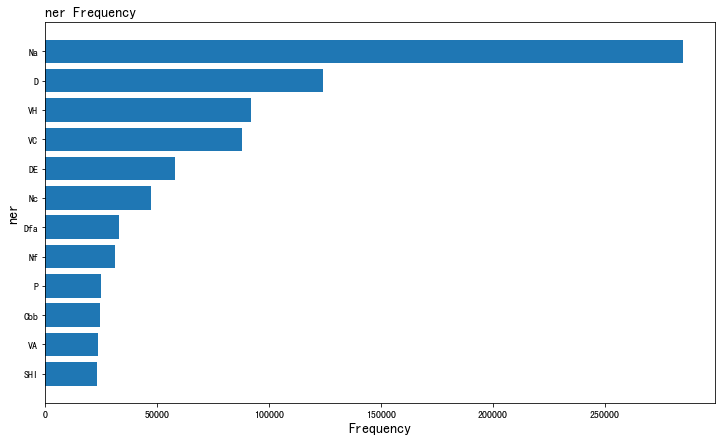

In [113]:
pos = pos_count['pos']
count = pos_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('ner Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

#### POS 詞性列表: 
+ 中研院列表: https://ckip.iis.sinica.edu.tw/service/corenlp/
    + Na: 普通名詞
    + D: 副詞
    + VC: 動作及物動詞
    + Nb: 專有名詞
    + FW: 外文
    + VH: 狀態不及物動詞
    + Nh: 代名詞
    + DE: 的之得地
    + P: 介詞
    + VA: 動作不及物動詞
    + T: 語助詞
    + SHI: 是

### 涉及到的名詞(Na)
+ 我們可以找出談論吃到飽時大部分討論到的專有名詞，探索大家的關注焦點。
+ 名詞可以分為「Na: 普通名詞」、「Nb: 專有名詞」等

In [114]:
# 篩選pos為名詞的資料
l_noun = ["Nb"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前15個
noun_count = noun[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
noun_count.head(10)

,word,count
445,哈根達斯,284
637,安格斯,220
1968,菲力,170
1162,松阪,141
1260,欣葉,129
1058,旭集,107
1558,王品,101
2606,黑牛,87
1135,杜,85
1941,莫凡彼,82


/var/folders/wb/4p2wtwfn0hbfl5wk9721_6gm0000gn/T/ipykernel_63821/502700507.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


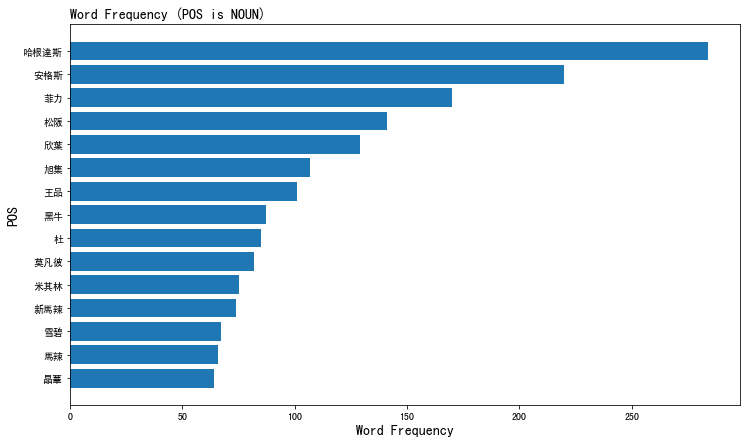

In [115]:
# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is NOUN)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

可以看到哈根達斯依舊是出現最多次的專有名詞，另外，從「安格斯」、「菲力」和「松阪」等專有名詞可以推測出大家對於肉類也有較高的討論度。

### 涉及到的動詞(VERB)
+ 我們可以找出談論吃到飽時大部分討論到的動詞，探索相關行為。
+ VC: 動作及物動詞、VH: 狀態不及物動詞、VA: 動作不及物動詞

In [117]:
l_verb = ["VC"] # ,"VH","VA"
verb = pos_table[pos_table.pos.isin(l_verb)] # 選取特定詞性
verb = verb[verb['word'].map(len) > 1] # 把長度為1的字去除掉

verb_count = verb[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
verb_count

,word,count
575,吃到,3954
3603,選擇,1738
1613,推薦,1632
1700,搭配,1632
2016,服務,1150
150,使用,652
585,吃完,595
104,享用,529
70,主打,357
541,參考,351


/var/folders/wb/4p2wtwfn0hbfl5wk9721_6gm0000gn/T/ipykernel_63821/2587760616.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


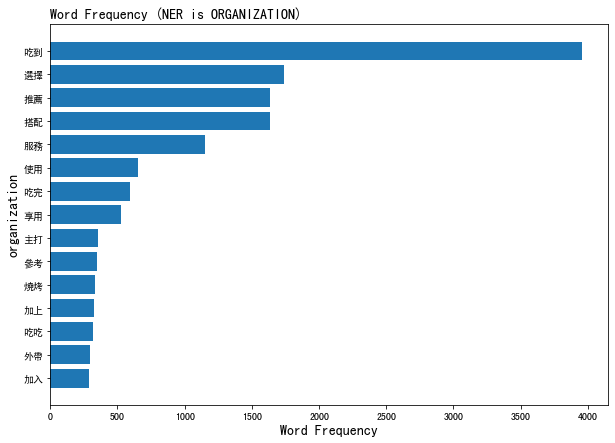

In [118]:
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = verb_count['word']
count = verb_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORGANIZATION)',loc ='left', size = 14)
ax.set_ylabel('organization', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

發現在貼文中的動詞，「吃到」佔了相當高的頻率，其他還有出現「選擇」、「搭配」等詞彙，可推測民眾對於食材的選擇多樣性有較高的重視程度。

In [120]:
# 看一下含特定關鍵字的貼文內容
keyword_list = ['吃到','選擇','搭配']
select = df[df['artContent'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{select.shape[0]}篇相關貼文")
select.head()

吃到 選擇 搭配：1578篇相關貼文


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,ideos,Food,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,[],111.250.1.231,2020-01-02 00:21:09,ptt
1,2,https://www.ptt.cc/bbs/Food/M.1577983692.A.794...,[抱怨]ATT4FUN乾杯點沙朗多注意,2020-01-02 16:42:10,justin81828,Food,餐廳名稱：乾杯\n\n 地址：ATT4FUN 乾杯\n 電話：02-87860808\n...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""KKyosuke"", ""...",118.169.82.96,2020-01-03 00:22:27,ptt
2,3,https://www.ptt.cc/bbs/Food/M.1577985452.A.477...,[食記]台北大安區六張犁站捷運小慧涼麵,2020-01-02 17:11:29,v84454058,Food,餐廳名稱：小慧涼麵\n 消費時間：2018年/11月起多訪\n 地址：台北市大安區臥...,[],123.194.196.149,2020-01-03 00:22:34,ptt
3,4,https://www.ptt.cc/bbs/Food/M.1578120136.A.276...,[食記]福岡-運河城旁國產牛燒肉-WEST,2020-01-04 06:36:14,Guyinkt,Food,消費時間：2019年/08月\n\n在運河城逛累了當然要吃東西補充體力了喔!\n\nWEST...,[],220.134.201.135,2020-01-05 00:21:43,ptt
4,5,https://www.ptt.cc/bbs/Food/M.1578125940.A.9AA...,[食記]長榮皇璽桂冠艙飛機餐SEA-TPE聖誕好運,2020-01-04 08:12:57,Sherlock56,Food,店名：長榮皇璽桂冠艙飛機餐\n 地址：無\n 電話：無\n 營業時間：依機艙供餐...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""swatseal"", ""...",121.109.166.209,2020-01-05 00:21:43,ptt


## 4. 利用SnowNLP進行情緒分析

+ SnowNLP 針對中文設計，可以提取句子的情緒分類
+ 使用文件分類法，套件已預先用文集訓練模型以判斷情緒
+ 情緒值在 0~1之間，代表負面到正面
+ 官方github: https://github.com/isnowfy/snownlp

In [127]:
from snownlp import SnowNLP
s = SnowNLP('文華訂位都訂不到，超難訂')
s.sentiments # 範圍在 0~ 1之間 (負面~正面)

0.01656963972992287

將句子和日期合併，方便之後做分析

In [143]:
sentence_table = pd.read_csv("raw_data/zh/sentence_table_buffet.csv") #匯資料
df = pd.read_csv("raw_data/zh/buffet_20_22.csv") #匯資料

sentiment_date = pd.merge(sentence_table,df[['system_id','artDate','dataSource']],on='system_id',how='left')
sentiment_date.head(3)

,system_id,sentence,artDate,dataSource
0,1,餐廳名稱濃咖哩,2020-01-02 05:09:58,ptt
1,1,消費時間年/月,2020-01-02 05:09:58,ptt
2,1,例年月，未提供則文章不予保留，多訪綜合心得也請標上起迄時間,2020-01-02 05:09:58,ptt


In [144]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head()

,system_id,sentence,artDate,dataSource,sentimentValue
0,1,餐廳名稱濃咖哩,2020-01-02 05:09:58,ptt,0.664289
1,1,消費時間年/月,2020-01-02 05:09:58,ptt,0.022688
2,1,例年月，未提供則文章不予保留，多訪綜合心得也請標上起迄時間,2020-01-02 05:09:58,ptt,0.001094
3,1,地址台北市開封街段巷號,2020-01-02 05:09:58,ptt,0.318909
4,1,電話,2020-01-02 05:09:58,ptt,0.152585


In [145]:
# 看一下情緒的分布
sentiment_date['sentimentValue'].describe()

count    1.241160e+05
mean     4.190400e-01
std      3.249403e-01
min      5.205993e-09
25%      1.093586e-01
50%      3.867990e-01
75%      6.969416e-01
max      1.000000e+00
Name: sentimentValue, dtype: float64

<AxesSubplot:>

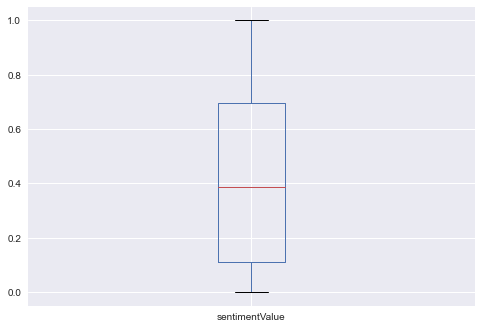

In [146]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

將每個月的情緒分數取平均，並轉換時間格式為年月

In [154]:
sent_date = sentiment_date.copy()
sent_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.to_period('M')

sentiment_count = sent_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()
sentiment_count.head()

,artDate,sentimentValue
0,2020-01,0.420074
1,2020-02,0.432450
2,2020-03,0.422305
3,2020-04,0.411733
4,2020-05,0.431685


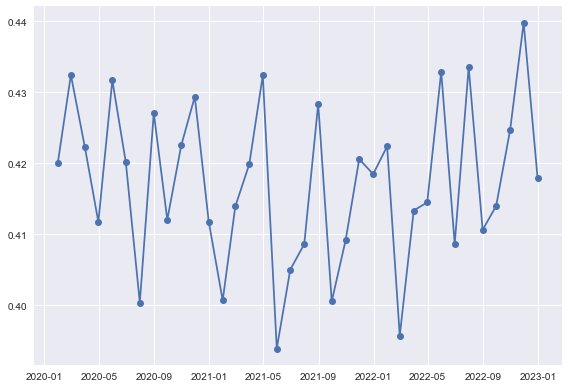

In [159]:
# 平均情緒分數時間趨勢
plt.style.use('seaborn')

months = sentiment_count['artDate']
y = sentiment_count['sentimentValue']

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate
plt.tight_layout()

plt.show()

從上圖中發現大部分天數的情緒值都在0.4~0.5之間，偏向中性，推測是因為PTT美食板上多數為食記類型的介紹文章。只是 2021年6月 和 2022年3月 的分數特別低，可以特別挑出來分析。

### 詞彙探索
從上圖中可以發現 2021年6月 和 2022年3月 的情緒分數特別低，我們把那兩個月的負面句子挑出來看看他們都用甚麼詞。

In [177]:
# 篩時間
filter_temp1 = sent_date[sent_date['artDate']=='2021-06']
filter_temp2 = sent_date[sent_date['artDate']=='2022-03']
filter_sentiment = pd.concat([filter_temp1, filter_temp2])
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] < 0.4]

filter_sentiment.head()

,system_id,sentence,artDate,dataSource,sentimentValue
75444,956,消費時間年/月,2021-06,ptt,0.022688
75446,956,電話,2021-06,ptt,0.152585
75447,956,營業時間平日假日,2021-06,ptt,0.130126
75449,956,可否刷卡可,2021-06,ptt,0.100183
75450,956,有無包廂無,2021-06,ptt,0.039451


In [181]:
# 把時間分數和之前斷詞的token table做 join
neg_words = pd.merge(filter_sentiment,pos_table,on='system_id',how='left')
neg_words = neg_words[['system_id','sentimentValue','word']]
neg_words.head()

,system_id,sentimentValue,word
0,956,0.022688,餐廳
1,956,0.022688,名稱
2,956,0.022688,消費
3,956,0.022688,時間
4,956,0.022688,年


In [182]:
# 篩選掉只有單個字元的結果
neg_words = neg_words[neg_words.apply(lambda x: len(x['word'])>1, axis=1)]

### 負面詞彙文字雲

In [190]:
# 自定停用字
with open('dict/stop_words.txt') as f:
    stop_words = f.read().splitlines()

print(stop_words)

[',', '?', '、', '。', '“', '”', '《', '》', '！', '，', '：', '；', '？', '可否', '有無', '再', '本來', '是不是', '一個', '這種', '人民', '末##末', '啊', '阿', '哎', '哎呀', '哎喲', '唉', '我', '我們', '按', '按照', '依照', '吧', '吧噠', '把', '罷了', '被', '本', '本著', '比', '比方', '比如', '鄙人', '彼', '彼此', '邊', '別', '別的', '別說', '並', '並且', '不比', '不成', '不單', '不但', '不獨', '不管', '不光', '不過', '不僅', '不拘', '不論', '不怕', '不然', '不如', '不特', '不惟', '不問', '不只', '朝', '朝著', '趁', '趁著', '乘', '沖', '除', '除此之外', '除非', '除了', '此', '此間', '此外', '從', '從而', '打', '待', '但', '但是', '當', '當著', '到', '得', '的', '的話', '等', '等等', '地', '第', '叮咚', '對', '對於', '多', '多少', '而', '而況', '而且', '而是', '而外', '而言', '而已', '爾後', '反過來', '反過來說', '反之', '非但', '非徒', '否則', '嘎', '嘎登', '該', '趕', '個', '各', '各個', '各位', '各種', '各自', '給', '根據', '跟', '故', '故此', '固然', '關於', '管', '歸', '果然', '果真', '過', '哈', '哈哈', '呵', '和', '何', '何處', '何況', '何時', '嘿', '哼', '哼唷', '呼哧', '乎', '嘩', '還是', '還有', '換句話說', '換言之', '或', '或是', '或者', '極了', '及', '及其', '及至', '即', '即便', '即或', '即令', '即若', '即使', '幾', '幾時', '己', '既', '既然', '既是', 

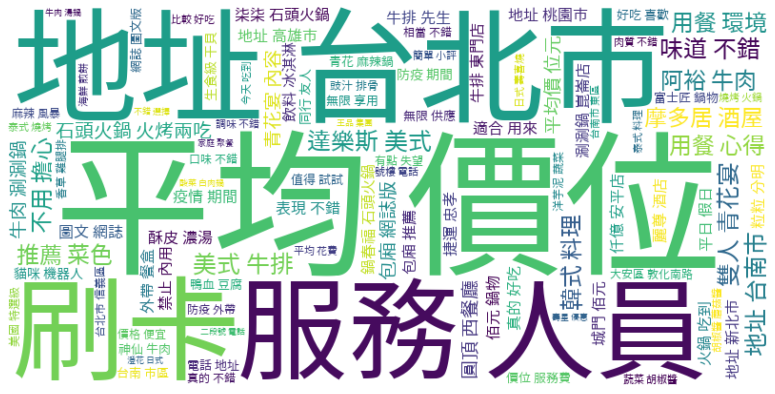

In [191]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
stop_words_pos.extend(('時間','營業','餐廳','覺得'))
stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,font_path=font_path,width=800, height = 400, max_words=100, background_color="white")

wordcloud.generate(' '.join(neg_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

在負面情緒的句子中，民眾多半討論到的是「價位」的部分，另外「人員」「服務」的討論度也不低，店家就可以根據這些方面去改善。